In [49]:
def expand_input_feature_arr_to_n_history_steps_feature_arr(num_history_step,feature_arr):  
    """
    This fuction takes the feature_arr of size [num_trial_in-the-sess , 1] and builds feature_array of n_step_history for model input for a single session

    output:  numpyarray size:[total number of trials of the selected session + -num_history_step + 1   , 2*num_history_step]
    Input:   feature_arr - size [num_trial_in-the-sess , 1]
             can be any feature array, input_choiceRightLeft, input_choiceNull, input_reward_array. 
    """
    num_history_step
    
    arr_history = np.zeros((feature_arr.shape[0]-num_history_step, num_history_step))

    for i in range(arr_history.shape[0]):
        arr_history[i] = feature_arr[i:i+num_history_step].T

    return arr_history

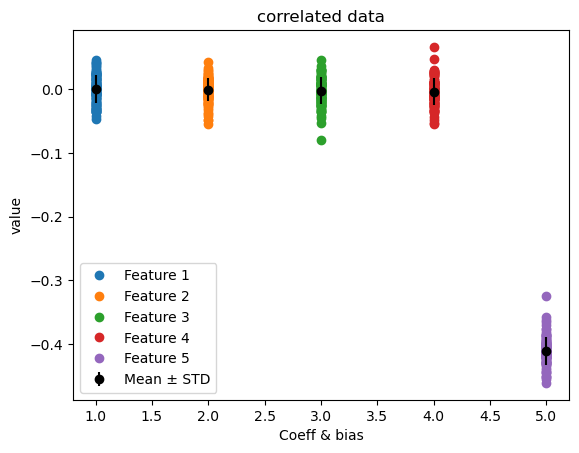

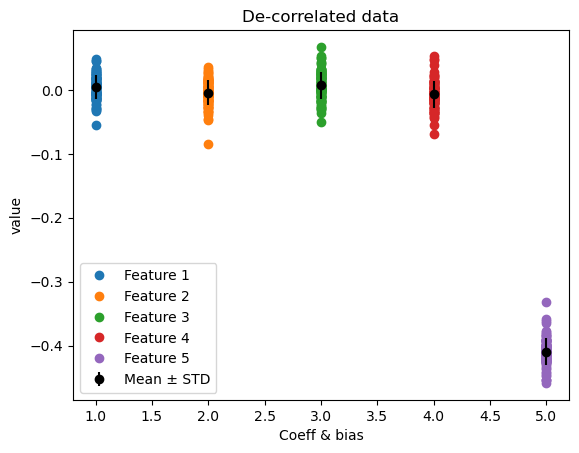

In [50]:
"""This experiment is a sanity check to check the outcome of a GLM on randomly distributed right and left choice. It is designed to check if some randomly distributied Right and Left might generate 
random patterns, which leads the GLM to output significant betas, while it is only fake. It also provides the required number of  datapoints.
The design matrix is history of choice.
Expectation of the outcome: data is randomly distributed , and choices are not made based on learning from past, or any mapping from past choice to predicct the current choice.
Therefore, I expect to see zero value for the beta coeff of of hitory steps, and only the bias term guide the p% probability of right side. This is Bernuolie random baseline model.
If the stattistical power is high enough, only the bias tern describes the outcomes, and other Betas are significantly smaller, (close to zero).
The statistical power in our data is of the order of 10,000. 
Both correlated and decorrelated data shows this result. 
We previousely used it is calculation of Relative LL as the baseline model.
Therefore there is no random pattren that on avarage may cause """


import numpy as np
from f_util_analyses import *
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


n=10000
p=.6
num_history_step=4
num_iter_ = 100
betas_corr, betas_decorr = np.zeros((num_history_step+1, num_iter_)) , np.zeros((num_history_step+1, num_iter_))


for i in range(num_iter_):
    array = np.random.choice([-1, 1], size=n, p=[p, 1-p])
    hist_array = expand_input_feature_arr_to_n_history_steps_feature_arr(num_history_step,array)
    output = array[num_history_step:].squeeze().copy()
    iinput=[]
    iinput.append(hist_array.copy())
    hist_array_list = decompose_input_list(iinput)

    # Fit the Bernoulli GLM to original data (correlated)
    model_corr_data = LogisticRegression(fit_intercept=True)
    model_corr_data.fit(hist_array, output)

    betas_corr[:num_history_step,i] = model_corr_data.coef_[0]
    betas_corr[-1,i] = model_corr_data.intercept_

    # Fit the Bernoulli GLM to decorrelated data
    model_decorr_data = LogisticRegression(fit_intercept=True)
    model_decorr_data.fit(hist_array_list[0], output)

    betas_decorr[:num_history_step,i] = model_decorr_data.coef_[0]
    betas_decorr[-1,i] = model_decorr_data.intercept_

    # print("Coefficients:", model.coef_)
    # print("Intercept:", model.intercept_)

mean = np.mean(betas_corr, axis=1)
sem = np.std(betas_corr, axis=1) #/ np.sqrt(betas_corr.shape[1])  # Standard Error of the Mean (SEM)

# Plot the values of all features against data points
fig, ax = plt.subplots()
for i in range(betas_corr.shape[0]):
    ax.plot(np.ones((num_iter_,))*(i+1), betas_corr[i,:],'o', label=f'Feature {i+1}')

# Plot mean and SEM for each feature
ax.errorbar(range(1,betas_corr.shape[0]+1), mean, yerr=sem, fmt='o', color='black', label='Mean ± STD')

ax.legend()
ax.set_title('correlated data')
ax.set_xlabel('Coeff & bias')
ax.set_ylabel('value')
plt.show()



mean_decor = np.mean(betas_decorr, axis=1)
sem_decor = np.std(betas_decorr, axis=1) #/ np.sqrt(betas_corr.shape[1])  # Standard Error of the Mean (SEM)

# Plot the values of all features against data points
fig1, ax1 = plt.subplots()
for i in range(betas_decorr.shape[0]):
    ax1.plot(np.ones((num_iter_,))*(i+1), betas_decorr[i,:],'o', label=f'Feature {i+1}')


# Plot mean and SEM for each feature
ax1.errorbar(range(1,betas_decorr.shape[0]+1), mean_decor, yerr=sem_decor, fmt='o', color='black', label='Mean ± STD')

ax1.legend()
ax1.set_title('De-correlated data')
ax1.set_xlabel('Coeff & bias')
ax1.set_ylabel('value')
plt.show()

In [51]:
betas_corr.shape

(5, 100)

/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Subdirectory 'data-aspects-dir' already exists for the file to be saved in.


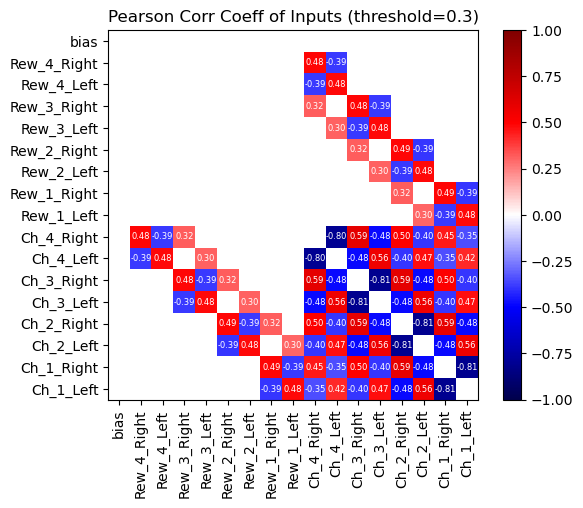

In [1]:
"""
the python environment for the code: conda activate ssm_env_python3_9 
type_save= 'data-aspects' # can be ['data-aspects' , 'HMM-latent-satas']
"""

from f_util_preprocess import *
from f_util_plot import *
from f_util_analyses import *

hparams = {
    'data_dir': get_path_to_data_dir(),
    'save_dir': get_path_to_save_dir(),
    'mouse' : 'HH10',
    'experiment' : 'blockRew-coupled-baited',
    'data_type' : '.npy',
    'num_history_step' : 4,
    'num_hidden_states' : [1,2,3],
    'GLM' : 'multinomial', # can be ['bernoulli' , 'multinomial']
    'bias' : True,
    'bias_to_rich' : False,
    'water' : False,
    'obs_dim' : 1 ,          # number of observed dimensions
    'num_categories' : 3,   # number of categories for output
    'cols' : set_color_pallete(),
    'analysis_experiment_name' : 'bias_RewardOneHot_ChoiceOneHot', # choose from the list ['modified_Bari', 'bias_RewardOneHot_ChoiceOneHot', 'just_bias']     ['just_bias', 'bias_RewardOneHot', 'bias_ChoiceOneHot', \
    # 'bias_RewardOneHot_ChoiceOneHot', 'bias_RewardOneHot_Choice1FeatureNAN', 'bias_RewardBinary_ChoiceOneHot', 'bias_RewardWSLS_1FeatureChoiceNAN', 
    # 'bias_RewardOrdinal_Choice1Hot', 'bias_RewardWSLS_ChoiceOneHot']
    'num_iters' : 500,
    'tolerance' : 10**-5,
    'alphas' : [1, 2],
    'sigmas' : [0.5, 2], #[0.5, 0.75, 1, 2, 3, 4] #[0.5, 2] # [2, 3] 
    'sessions' : np.arange(1,61),
    'output_form' : 'R0_nan1_L2',  # can be chosen from ['R0_L1_nan2', 'R0_nan1_L2']
    'observation_dim' : 1,
    'n_iters' : 500,
    'colors' : ['#ff7f00', '#4daf4a', '#377eb8', '#f781bf', '#999999','#e41a1c', '#dede00', '#a65628', '#984ea3', '#97945a', '#c1cdc1',\
    '#00FFFF', '#FF00FF', '#FFA500', '#7FFFD4', '#00008B', '#00FF00', '#F7E7CE', '#EAC117', '#B275F7', '#9FDEBF'],
    'category_rew_prob' : [0.45,  0.4,   0.386, 0.338, 0.225, 0.113, 0.071, 0.064, 0.05 ],
    
}



hparams['input_dim'] = n_input_dim(hparams)
hparams['alpha_sigma_sets'] = generate_hyperparameter_sets_for_mle_map(hparams['alphas'] , hparams['sigmas']) #"alpha_sigma_sets" used to be "hyperparameter_sets"

data = import_data(hparams['data_dir'] + hparams['mouse'] + hparams['data_type']) # DataFrame of size 5*n_sessions, 
# To call data of, for example, choice_history of session 2, use this form: data[2]['choice_history'], which is a numpy.ndarray of size (1 , n_trilas)

    # ''' 
    # Export all foraging sessions (for Faeze)
    #
    # The dictionary in each .npy file uses session number as the key
    # {1: {'choice_history': 1-d array, 0 = left, 1 = right, nan = ignored
    #      'reward_history': 2-d array, first dimension: left [0] / right [1], second dimension: trial number. 0 = no reward, 1 = rewarded
    #      'p_reward': underlying reward refill probabilities. Same structure as reward_history
    #      'trial_num': total trial number (including ignored trials)
    #      'foraging_efficiency': overall performance of this session
    #      },
    #  2: data for session 2,
    #  ...
    # }
    # '''

hparams['tot_n_sess'] = np.shape(data)[1]
hparams['list_of_trial_count_in_chosen_sessens'] = get_list_of_trial_count_in_chosen_sessens(hparams, data)
hparams['num_input_trials_segr_by_sessions'] = get_list_of_num_trials_for_chosen_sess_in_input_array(hparams)
hparams['input_labels'] = get_input_labels(hparams)
hparams['num_trials_in_input_array'] = get_n_trials_for_input_array(hparams)
if hparams['GLM'] == 'multinomial':
    hparams['num_categories'] = 3
else:
    hparams['num_categories'] = 2


input_design_matrix_list = build_input_design_matrix(hparams, data)
output_choice_list = build_output_choice_list(hparams, data)

if np.shape(input_design_matrix_list)[2] > 1:
    plot_heatmap_of_pearson_corr_coeff_of_input_data(hparams, input_design_matrix_list, threshold = 0.3)
    plot_name = 'pearson_coeff' + '-' + hparams['mouse'] + '-' + hparams['analysis_experiment_name']
    save_plot(hparams, type_save= 'data-aspects', plot_name = plot_name)


### fold stuff to be done later ###
# num_folds = 5 # num_fold in training part
# num_folds_tt = num_folds +1
# test_fold_id = np.random.randint(0,num_folds+1, 1)
# # test_fold_id =0 ##############remive it

# print('test_fold_id : ', test_fold_id)

/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


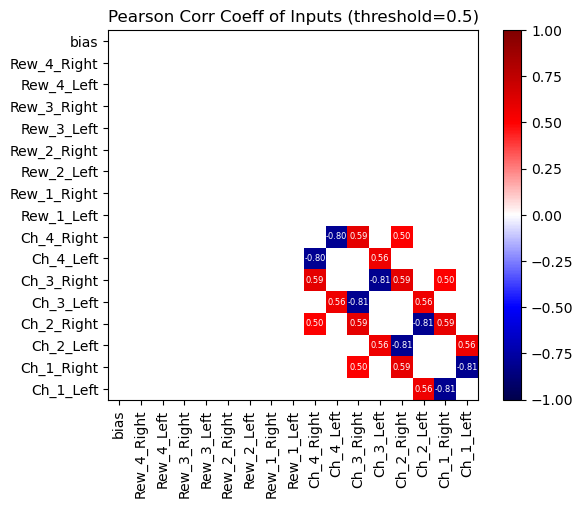

In [2]:
import ssm

"""
n_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
"""

hparams_analyses = {
    'decorrelate_input' : False,
}


# npr.seed(0)
# Set the parameters of the GLM-HMM
# num_states =  2      # number of discrete states
obs_dim = hparams['observation_dim']        # number of observed dimensions
num_categories = hparams['num_categories']    # number of categories for output
input_dim = hparams['input_dim']         # input dimensions


if hparams_analyses['decorrelate_input'] == True: 
    input_design_matrix_list = decompose_input_list(input_design_matrix_list)
    # a,b,pca_ = decompose_input_list(input_design_matrix_list)
    hparams['input_labels'] = ['PC' + str(i) for i in range(1, hparams['input_dim']+1)]
    
if np.shape(input_design_matrix_list)[2] > 1:
    plot_heatmap_of_pearson_corr_coeff_of_input_data(hparams, input_design_matrix_list, threshold = 0.5)


true_choices = output_choice_list
inpts = input_design_matrix_list


# mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                    observation_kwargs=dict(C=num_categories), transitions="standard")

In [3]:
"""use input from the real data
build a glm model using n arbitrary num_states
set the weights and A and #hidden_states as you wish
generate fake choice outcput using given the W,A,and n-states"""

# set num_hidden_states
num_states = 3

# build GLM-HMM object
mle_glmhmm_simul = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories), transitions="standard")


# Set weights of multinomial GLM-HMM
gen_weights = np.random.uniform(low=-3, high=6, size=(num_states, num_categories-1, input_dim))
print(gen_weights.shape) 
mle_glmhmm_simul.observations.params = gen_weights

# Set transition matrix of multinomial GLM-HMM
# gen_log_trans_mat = np.log(np.array([[[0.90, 0.04, 0.05, 0.01], [0.05, 0.92, 0.01, 0.02], [0.03, 0.02, 0.94, 0.01], [0.09, 0.01, 0.01, 0.89]]]))
gen_log_trans_mat = np.log(np.array([[[0.90, 0.04, 0.06], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
mle_glmhmm_simul.transitions.params = gen_log_trans_mat


# Generate a sequence of latents and choices for each session (given  model parameters i.e. weights, transotion prob, and num_states)
true_latents_simul, true_choices_simul = [], []
for sess in range(1):
    true_z, true_y = mle_glmhmm_simul.sample(np.shape(inpts)[1], input=inpts[sess])
    true_latents_simul.append(true_z)
    true_choices_simul.append(true_y)



(3, 2, 17)


In [4]:
"""1st Test:for simulated data choice, perform CV. chech if it can recover the num_hidden_states.
"""
num_states_2cv = range(1,5)
n_repeats=3
heldout_frac=.1

test_ll, train_ll = cv(hparams, num_states_2cv= num_states_2cv, n_repeats=n_repeats, heldout_frac=heldout_frac, inpts=inpts, true_choices= true_choices_simul)

print('test', test_ll)
print('train',train_ll)

1


LP: -20718.3: 100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


test [-0.59292932 -0.58046955 -0.58609227]
train [-0.58865804 -0.59004229 -0.58941762]
2


LP: -17186.0: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


test [-0.29003873 -0.28713987 -0.43148096]
train [-0.36653781 -0.36695525 -0.47995083]
3


LP: -12478.4: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


test [-0.24299365 -0.23842206 -0.25115906]
train [-0.33740703 -0.33735223 -0.33661221]
4


LP: -12724.4: 100%|██████████| 100/100 [00:36<00:00,  2.76it/s]

test [-0.24441459 -0.2689928  -0.26462405]
train [-0.33777637 -0.33518822 -0.33603238]
test [array([-0.59292932, -0.58046955, -0.58609227]), array([-0.29003873, -0.28713987, -0.43148096]), array([-0.24299365, -0.23842206, -0.25115906]), array([-0.24441459, -0.2689928 , -0.26462405])]
train [array([-0.58865804, -0.59004229, -0.58941762]), array([-0.36653781, -0.36695525, -0.47995083]), array([-0.33740703, -0.33735223, -0.33661221]), array([-0.33777637, -0.33518822, -0.33603238])]


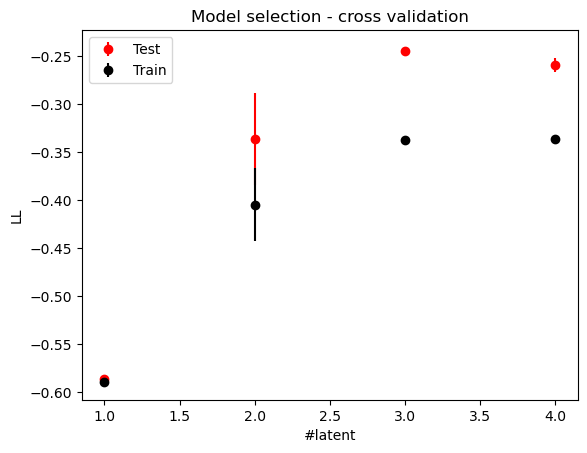

In [5]:
plot_LL_for_model_selection(test_ll, train_ll, num_states_2cv)

In [248]:
# Calculate true loglikelihood
true_ll = mle_glmhmm_simul.log_probability(true_choices_simul, inputs=inpts) 
print("true_ll per trial = " + str(true_ll/hparams['num_trials_in_input_array']))

true_ll per trial = -0.342105457422373


In [249]:
# fit GLM-HMM
infered_num_state = 3
new_glmhmm = ssm.HMM(infered_num_state, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices_simul, inputs=inpts, method="em", num_iters=hparams['n_iters'], tolerance=10**-4)


Converged to LP: -13143.6:  16%|█▌        | 80/500 [00:35<03:03,  2.28it/s]


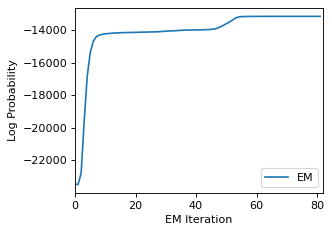

In [250]:
#Plot the log probabilities of the true and fit models. Fit model final LL should be greater than or equal to true LL.
plot_log_prob_of_model_vs_EM_iteration_output_of_fit_fun_training_progress(fit_ll)

In [251]:
# # permute recovered state identities to match state identities of generative model
# from ssm.util import find_permutation
# new_glmhmm.permute(find_permutation(true_latents_simul[0], new_glmhmm.most_likely_states(true_choices_simul[0], input=inpts[0])))

/var/folders/r9/b7xk0p4523sg5rc0lhnngn_40000gn/T/ipykernel_63958/1622050677.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, num_categories+1, c+1)


Text(0.5, 1.0, 'Recovered transition matrix')

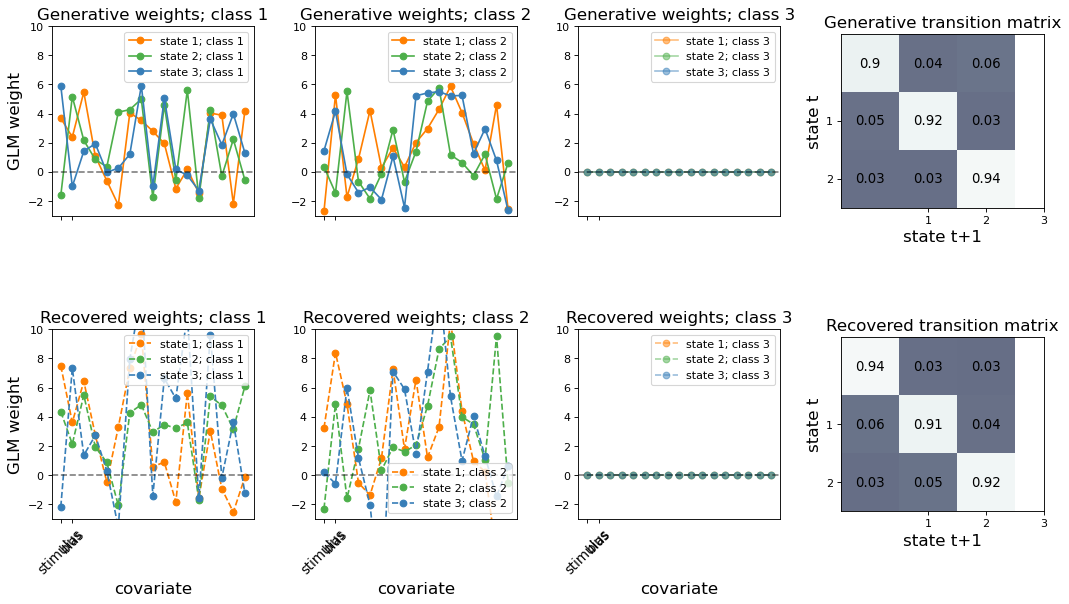

In [252]:
# Plot recovered parameters:
recovered_weights = new_glmhmm.observations.params
recovered_transitions = new_glmhmm.transitions.params

fig = plt.figure(figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.6)

plt.subplot(2, 2, 1)
cols = hparams['colors']

for c in range(num_categories):
    plt.subplot(2, num_categories+1, c+1)
    if c < num_categories-1:
        for k in range(num_states):
            plt.plot(range(input_dim), gen_weights[k,c], marker='o',
                 color=cols[k], lw=1.5, label="state " + str(k+1) + "; class " + str(c+1))
    else:
        for k in range(num_states):
            plt.plot(range(input_dim), np.zeros(input_dim), marker='o',
                     color=cols[k], lw=1.5, label="state " + str(k+1) + "; class " + str(c+1), alpha = 0.5)

    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.yticks(fontsize=10)
    plt.xticks([0, 1], ['', ''])
    if c == 0:
        plt.ylabel("GLM weight", fontsize=15)
    plt.legend()
    plt.title("Generative weights; class " + str(c+1), fontsize = 15)
    plt.ylim((-3, 10))
    
plt.subplot(2, num_categories+1, num_categories+1)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(1, num_states+1), fontsize=10)
plt.yticks(range(1, num_states+1), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)


cols = hparams['colors']#['#ff7f00', '#4daf4a', '#377eb8', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

for c in range(num_categories):
    plt.subplot(2, num_categories+1, num_categories + c + 2)
    if c < num_categories-1:
        for k in range(infered_num_state):
            plt.plot(range(input_dim), recovered_weights[k,c], marker='o', linestyle = '--',
                 color=cols[k], lw=1.5, label="state " + str(k+1) + "; class " + str(c+1))
    else:
        for k in range(infered_num_state):
            plt.plot(range(input_dim), np.zeros(input_dim), marker='o', linestyle = '--',
                     color=cols[k], lw=1.5, label="state " + str(k+1) + "; class " + str(c+1), alpha = 0.5)

    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.yticks(fontsize=10)
    plt.xlabel("covariate", fontsize=15)
    if c == 0:
        plt.ylabel("GLM weight", fontsize=15)
    plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
    plt.legend()
    plt.title("Recovered weights; class " + str(c+1), fontsize = 15)
    plt.ylim((-3,10))
    
plt.subplot(2, num_categories+1, 2*num_categories+2)
recovered_trans_mat = np.exp(recovered_transitions)[0]
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, infered_num_state - 0.5)
plt.xticks(range(1, infered_num_state+1), fontsize=10)
plt.yticks(range(1, infered_num_state+1), fontsize=10)
plt.ylim(infered_num_state - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Recovered transition matrix", fontsize = 15)

[[ 4.07998565 94.80810617  1.11190818]
 [20.70600632  1.65964173 77.63435195]
 [86.08717372  2.67266142 11.24016486]]


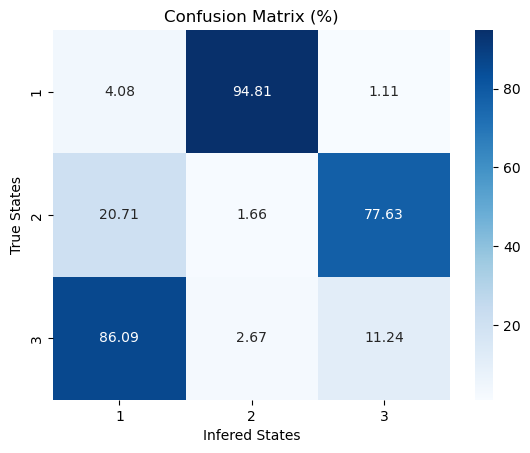

In [253]:
# Get expected states:
posterior_probs_decor = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices_simul, inpts)]


# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs_decor)
# get state with maximum posterior probability at particular trial:
state_max_posterior_decor = np.argmax(posterior_probs_concat, axis = 1)

# # permute recovered state identities to match state identities of generative model
# state_max_posterior_decor = permute_array(np.array(true_latents_simul).squeeze(), state_max_posterior_decor)

# Count the number of occurrences of each pair of values
counts = np.bincount(infered_num_state * np.array(true_latents_simul).squeeze() + state_max_posterior_decor, minlength=infered_num_state**2).reshape(infered_num_state, infered_num_state)

# Calculate row sums for normalization
row_sums = counts.sum(axis=1, keepdims=True)

# Calculate the percentage matrix
percentage_matrix = (counts / row_sums) * 100

# Print the confusion matrix
print(percentage_matrix)

# Plot the confusion matrix as a heatmap
sns.heatmap(percentage_matrix, annot=True, cmap='Blues', fmt='.2f')

# Set the x-axis and y-axis tick labels
tick_labels = [str(i+1) for i in range(infered_num_state)]
plt.xticks(np.arange(infered_num_state)+.5, tick_labels)
plt.yticks(np.arange(infered_num_state)+.5, tick_labels)

# Set the axis labels
plt.xlabel('Infered States')
plt.ylabel('True States')

# Set the plot title
plt.title('Confusion Matrix (%)')

# Display the plot
plt.show()

In [254]:
# state_max_posterior_decor_to_chack = state_max_posterior_decor

In [255]:
np.sum(state_max_posterior_decor_to_chack == state_max_posterior_decor)/hparams['num_trials_in_input_array']

0.0011931317113658764

In [256]:
state_max_posterior_decor[:50]

array([2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

Text(0, 0.5, 'loglikelihood')

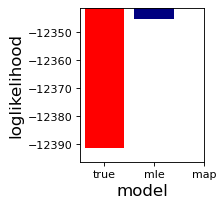

In [257]:
"""Compare final likelihood of data with MAP estimation and MLE to likelihood under generative model (note: we cannot use log_probability that is output of `fit` function as this 
incorporates prior term, which is not comparable between generative and MAP models). We want to check that MAP and MLE likelihood values are higher than true likelihood; if they are not, 
this may indicate a poor initialization and that we should refit these models."""

true_likelihood = mle_glmhmm_simul.log_likelihood(true_choices_simul, inputs=inpts) #/ hparams['num_trials_in_input_array']
mle_final_ll = new_glmhmm.log_likelihood(true_choices_simul, inputs=inpts) #/ hparams['num_trials_in_input_array']
# map_final_ll = map_glmhmm.log_likelihood(true_choices, inputs=inpts) 

# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [true_likelihood, mle_final_ll]
colors = ['Red', 'Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((true_likelihood-5, true_likelihood+50))
plt.xticks([0, 1, 2], ['true', 'mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

In [258]:
print("mle_final_ll = ", mle_final_ll)

mle_final_ll =  -12345.275510278187


In [259]:
hh

NameError: name 'hh' is not defined

In [ ]:
"""2nd test: generate highly correlated data as input. or any data which causes multicollinearity in the model.
set W, A, #states.
build glm-hmm object with selected #states.
generate true_choise_simul by sampling from the model.

decorrelate the input using PCA
fit the data to recover weights', A, 

inverse_transform weights'
check if original weights can be recovered
"""


# npr.seed(0)
# Set the parameters of the GLM-HMM
num_states =  2      # number of discrete states
obs_dim = hparams['observation_dim']        # number of observed dimensions
num_categories = hparams['num_categories']    # number of categories for output
input_dim = hparams['input_dim']         # input dimensions

    


import ssm
# pick a correlated data input
input_design_matrix_list = build_input_design_matrix(hparams, data)
inpts = input_design_matrix_list

# set num_hidden_states
num_states = 3

# build GLM-HMM object
mle_glmhmm_simul = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories), transitions="standard")


# Set weights of multinomial GLM-HMM
gen_weights = np.random.uniform(low=-3, high=6, size=(num_states, num_categories-1, input_dim))
print(gen_weights.shape) 
mle_glmhmm_simul.observations.params = gen_weights

# Set transition matrix of multinomial GLM-HMM
# gen_log_trans_mat = np.log(np.array([[[0.90, 0.04, 0.05, 0.01], [0.05, 0.92, 0.01, 0.02], [0.03, 0.02, 0.94, 0.01], [0.09, 0.01, 0.01, 0.89]]]))
gen_log_trans_mat = np.log(np.array([[[0.90, 0.04, 0.06], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
mle_glmhmm_simul.transitions.params = gen_log_trans_mat


# Generate a sequence of latents and choices for each session (given  model parameters i.e. weights, transotion prob, and num_states)
true_latents_simul, true_choices_simul = [], []
for sess in range(1):
    true_z, true_y = mle_glmhmm_simul.sample(np.shape(inpts)[1], input=inpts[sess])
    true_latents_simul.append(true_z)
    true_choices_simul.append(true_y)


/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(3, 2, 17)


In [ ]:
np.shape(input_design_matrix_list)

(1, 38554, 17)

In [ ]:
# Calculate true loglikelihood
true_ll = mle_glmhmm_simul.log_probability(true_choices_simul, inputs=inpts) 
print("true_ll per trial = " + str(true_ll/hparams['num_trials_in_input_array']))

true_ll per trial = -0.4155802265115512


In [ ]:
# pc data
input_design_matrix_list_decor, loadings, pca_object = decompose_input_list(input_design_matrix_list)
# a,b,pca_ = decompose_input_list(input_design_matrix_list)
hparams['input_labels'] = ['PC' + str(i) for i in range(1, hparams['input_dim']+1)]

inpts_decor = input_design_matrix_list_decor

In [ ]:
# fit GLM-HMM
infered_num_state = 3
new_glmhmm_decor = ssm.HMM(infered_num_state, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll_decor = new_glmhmm_decor.fit(true_choices_simul, inputs=inpts_decor, method="em", num_iters=hparams['n_iters'], tolerance=10**-4)

Converged to LP: -19657.9:   7%|▋         | 35/500 [00:14<03:07,  2.48it/s]


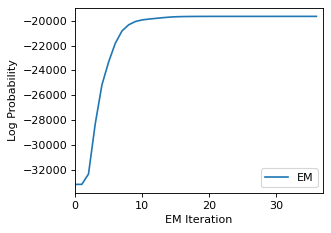

In [ ]:
#Plot the log probabilities of the true and fit models. Fit model final LL should be greater than or equal to true LL.
plot_log_prob_of_model_vs_EM_iteration_output_of_fit_fun_training_progress(fit_ll_decor)

In [ ]:
recovered_weights = new_glmhmm_decor.observations.params
recovered_transitions = new_glmhmm_decor.transitions.params

In [ ]:
# # recovered_weights_decor  inpts_decor sample

# # build GLM-HMM object
# mle_glmhmm_simul_decor_recov = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                 observation_kwargs=dict(C=num_categories), transitions="standard")

# mle_glmhmm_simul_decor_recov.observations.params = recovered_weights_decor

# mle_glmhmm_simul_decor_recov.transitions.params = gen_log_trans_mat

# # Generate a sequence of latents and choices for each session (given  model parameters i.e. weights, transotion prob, and num_states)
# true_latents_simul_decor_recov, true_choices_simul_decor_recov = [], []
# for sess in range(1):
#     true_z, true_y = mle_glmhmm_simul.sample(np.shape(inpts_decor)[1], input=inpts_decor[sess])
#     true_latents_simul_decor_recov.append(true_z)
#     true_choices_simul_decor_recov.append(true_y)

In [ ]:
# recovered_weights_decor = recovered_weights_decor.reshape(-1,input_dim)
# recovered_weights = pca_object.inverse_transform(recovered_weights_decor).reshape(infered_num_state, num_categories-1,input_dim)


/var/folders/r9/b7xk0p4523sg5rc0lhnngn_40000gn/T/ipykernel_60110/1524408182.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, num_categories+1, c+1)


Text(0.5, 1.0, 'Recovered transition matrix')

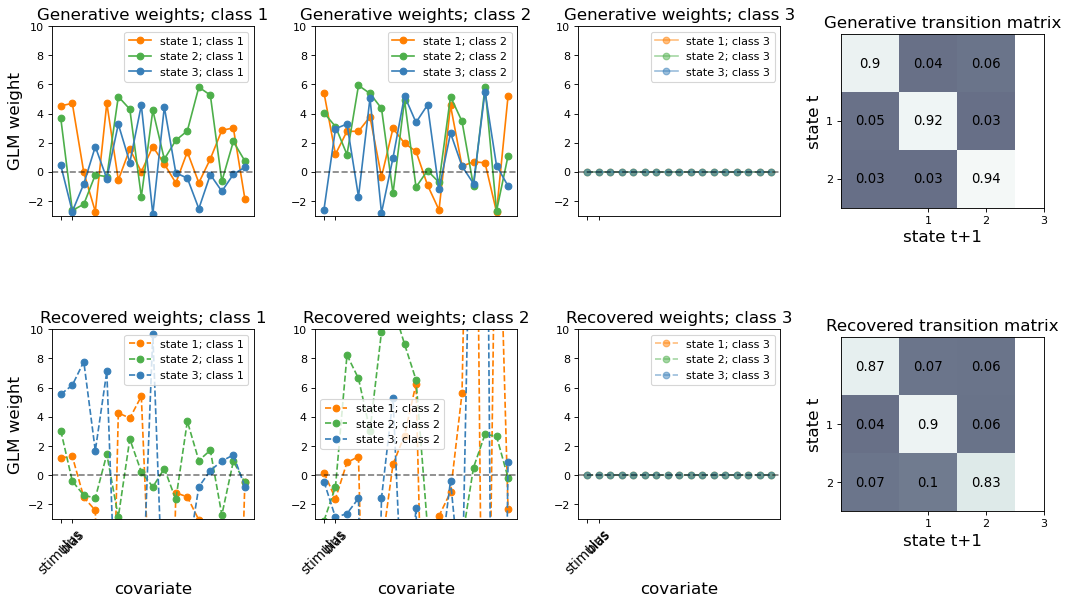

In [ ]:
# # Plot recovered parameters:
# recovered_weights = new_glmhmm.observations.params
# recovered_transitions = new_glmhmm.transitions.params

fig = plt.figure(figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.6)

plt.subplot(2, 2, 1)
cols = hparams['colors']

for c in range(num_categories):
    plt.subplot(2, num_categories+1, c+1)
    if c < num_categories-1:
        for k in range(num_states):
            plt.plot(range(input_dim), gen_weights[k,c], marker='o',
                 color=cols[k], lw=1.5, label="state " + str(k+1) + "; class " + str(c+1))
    else:
        for k in range(num_states):
            plt.plot(range(input_dim), np.zeros(input_dim), marker='o',
                     color=cols[k], lw=1.5, label="state " + str(k+1) + "; class " + str(c+1), alpha = 0.5)

    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.yticks(fontsize=10)
    plt.xticks([0, 1], ['', ''])
    if c == 0:
        plt.ylabel("GLM weight", fontsize=15)
    plt.legend()
    plt.title("Generative weights; class " + str(c+1), fontsize = 15)
    plt.ylim((-3, 10))
    
plt.subplot(2, num_categories+1, num_categories+1)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(1, num_states+1), fontsize=10)
plt.yticks(range(1, num_states+1), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)


cols = hparams['colors']#['#ff7f00', '#4daf4a', '#377eb8', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

for c in range(num_categories):
    plt.subplot(2, num_categories+1, num_categories + c + 2)
    if c < num_categories-1:
        for k in range(infered_num_state):
            plt.plot(range(input_dim), recovered_weights[k,c], marker='o', linestyle = '--',
                 color=cols[k], lw=1.5, label="state " + str(k+1) + "; class " + str(c+1))
    else:
        for k in range(infered_num_state):
            plt.plot(range(input_dim), np.zeros(input_dim), marker='o', linestyle = '--',
                     color=cols[k], lw=1.5, label="state " + str(k+1) + "; class " + str(c+1), alpha = 0.5)

    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.yticks(fontsize=10)
    plt.xlabel("covariate", fontsize=15)
    if c == 0:
        plt.ylabel("GLM weight", fontsize=15)
    plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
    plt.legend()
    plt.title("Recovered weights; class " + str(c+1), fontsize = 15)
    plt.ylim((-3,10))
    
plt.subplot(2, num_categories+1, 2*num_categories+2)
recovered_trans_mat = np.exp(recovered_transitions)[0]
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, infered_num_state - 0.5)
plt.xticks(range(1, infered_num_state+1), fontsize=10)
plt.yticks(range(1, infered_num_state+1), fontsize=10)
plt.ylim(infered_num_state - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Recovered transition matrix", fontsize = 15)

Best replacement fo far: 01, Count: 12065
Best replacement fo far: 10, Count: 12065
Best replacement fo far: 12, Count: 15943
Best replacement fo far: 21, Count: 15943
[[  909  7156  2460]
 [ 8647  1266  2200]
 [ 1190   958 13768]]


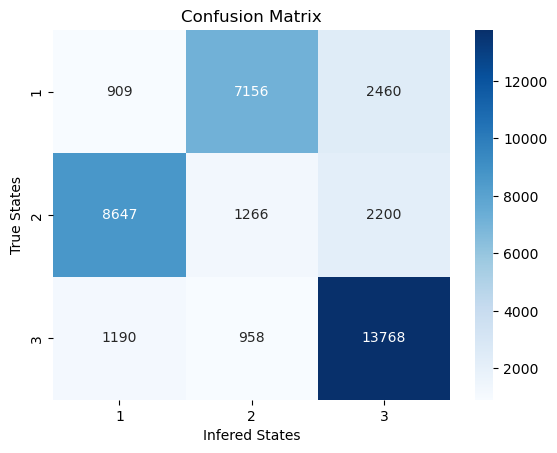

In [ ]:
# Get expected states:
posterior_probs_decor = [new_glmhmm_decor.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices_simul, inpts_decor)]


# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs_decor)
# get state with maximum posterior probability at particular trial:
state_max_posterior_decor = np.argmax(posterior_probs_concat, axis = 1)

# permute recovered state identities to match state identities of generative model
state_max_posterior_decor = permute_array(np.array(true_latents_simul).squeeze(), state_max_posterior_decor)

# Count the number of occurrences of each pair of values
counts = np.bincount(infered_num_state * np.array(true_latents_simul).squeeze() + state_max_posterior_decor, minlength=infered_num_state**2).reshape(infered_num_state, infered_num_state)

# Print the confusion matrix
print(counts)

# Plot the confusion matrix as a heatmap
sns.heatmap(counts, annot=True, cmap='Blues', fmt='d')

# Set the x-axis and y-axis tick labels
tick_labels = [str(i+1) for i in range(infered_num_state)]
plt.xticks(np.arange(infered_num_state)+.5, tick_labels)
plt.yticks(np.arange(infered_num_state)+.5, tick_labels)

# Set the axis labels
plt.xlabel('Infered States')
plt.ylabel('True States')

# Set the plot title
plt.title('Confusion Matrix')

# Display the plot
plt.show()